# Entrega 5 CNN

Primero vamos a comprobar que tenemos GPU disponible

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7542543118080064671
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3353083904
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13956783367450916627
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1050, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


Ahora vamos a cargar el dataset, en esta caso CIFAR10. Este contiene 50000 imágenes a color de 32x32 para el entrenamiento y 10000 para el test, divididas en 10 categorias.

In [2]:
import tensorflow.keras
from tensorflow.keras.datasets import cifar10

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)
(50000, 1)
(10000, 1)


truck


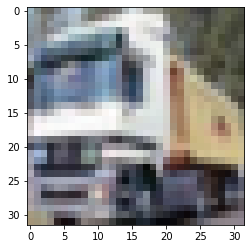

In [3]:
import matplotlib.pyplot as plt

# Creamos las categorias para poder interpretar los resultados
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.imshow(x_train[1])
print(class_names[y_train[1][0]])

Preparamos los datos

In [9]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Se normalizan las imagenes. Cada canal del pixel entre 0. y 1.
# x_train = x_train.astype('float32') / 255
# x_test = x_test.astype('float32') / 255

# Creamos el One Hot para las clases
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)



datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow(x_train, y_train, batch_size=32, subset='training')

validation_generator = datagen.flow(x_train, y_train, batch_size=8, subset='validation')

# fits the model on batches with real-time data augmentation:
# model.fit(datagen.flow(x_train, y_train, batch_size=32,
#          subset='training'),
#          validation_data=datagen.flow(x_train, y_train,
#          batch_size=8, subset='validation'),
#          steps_per_epoch=len(x_train) / 32, epochs=epochs)


Creamos el modelo

In [10]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import losses
from tensorflow.keras import optimizers



model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(32,32,3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(64, activation='relu'))
# model.add(layers.Dropout(0.2))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

#Adaptive learning rate (adaDelta) funciona muy bien en CNN rivalizando con adam y adagrad
#la función de pérdida para clasificación categorical crossentropy
model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers.Adadelta(),
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

Entrenamos el modelo

In [14]:
batch_size = 40
num_epoch = 10

model_log = model.fit(train_generator,
          epochs=num_epoch,
          verbose=1,
          validation_data=validation_generator,
          steps_per_epoch=len(x_train) / 32)

Epoch 1/10


ValueError: in user code:

    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:755 train_step
        loss = self.compiled_loss(
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/engine/compile_utils.py:203 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:152 __call__
        losses = call_fn(y_true, y_pred)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:256 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/losses.py:1537 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/keras/backend.py:4833 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /home/alvaro/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None, None, None, None, None, None) and (None, 10) are incompatible


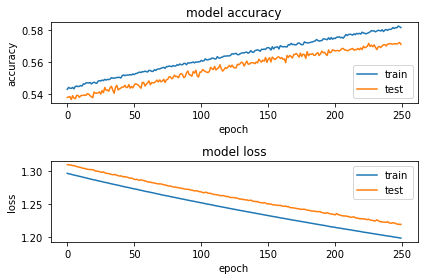

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(model_log.history['accuracy'])
plt.plot(model_log.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.subplot(2,1,2)
plt.plot(model_log.history['loss'])
plt.plot(model_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.tight_layout()

Resultados:

    - epochs 250, batch_size 10 -> loss: 1.2901 - accuracy: 0.5482 - val_loss: 1.3121 - val_accuracy: 0.5358 (~1 hora)
    
    - (Con los pesos anteriores) epochs 250, batch_size 40 -> loss: 1.1985 - accuracy: 0.5817 - val_loss: 1.2194 - val_accuracy: 0.5712 (~20 min)

In [53]:
#Save the model
# serialize model to JSON
model_digit_json = model.to_json()
with open("modelCNN1_digit.json", "w") as json_file:
    json_file.write(model_digit_json)
# serialize weights to HDF5
model.save_weights("modelCNN1_digit.h5")
print("Saved model to disk")

Saved model to disk
